In [1]:
import torch

In [2]:
from load_data import *

In [3]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_adult_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

{'race': array([0., 4., 4., ..., 4., 4., 4.]), 'sex': array([1., 0., 1., ..., 1., 0., 1.])}
for others min:  0 and max:  1
45222
(45222, 2)


In [4]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print(ytr[:10].flatten())
print(Ztr[110:120])

# training samples: (31655, 50)
# test samples: (13567, 50)
[0. 0. 0. 0. 1. 0. 1. 1. 1. 0.]
[[4. 1.]
 [4. 1.]
 [4. 0.]
 [4. 0.]
 [2. 0.]
 [4. 1.]
 [4. 1.]
 [4. 1.]
 [4. 1.]
 [4. 1.]]


In [5]:
N1 = 200
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [6]:
from load_data import *

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return torch.sigmoid(self.network(x))

In [9]:
n_features = Xtr.shape[1]
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [10]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

# GPU setting

In [11]:
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  0
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

In [12]:
from torch.utils.tensorboard import SummaryWriter

In [21]:
writer = SummaryWriter('../results/adult_data_practice')

In [12]:
class args:
    epochs = 100
    log_interval = 100

In [13]:
from pierogi.pierogi import Pierogi

In [14]:
def train_model(model, train_loader, criterion, optimizer, device, args):
    with Pierogi() as pierogi:
        pierogi.configure(nb_epochs=args.epochs,
                          nb_batches_per_epoch=len(train_loader))
        for epoch in range(args.epochs):
            for batch_idx, (x,y, _) in enumerate(train_loader):
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                p_y = model(x)
                loss = criterion(p_y, y)
                loss.backward()
                optimizer.step()
                if batch_idx % args.log_interval ==0:
                    message = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item())
                    print(message)
                    pierogi.plot_loss(epoch, batch_idx, loss.item())
        
        input("Press enter to exit")

In [27]:
def train_model(model, train_loader, criterion, optimizer, device, args):
   
    running_loss = 0.0
    for epoch in range(args.epochs):
        for batch_idx, (x,y, _) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            p_y = model(x)
            loss = criterion(p_y, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if batch_idx % args.log_interval ==0:
                writer.add_scalar('training loss', running_loss/args.log_interval,
                                 epoch * len(train_loader) + batch_idx)
                running_loss = 0.0
    print('Finished Training')

In [13]:
class AverageVarMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val=0
        self.sum2 = 0
        self.avg=0
        self.sum=0
        self.count=0

    def update(self,val,n=1):
        self.val = val
        self.sum2 += (val**2)*n
        self.sum +=val*n
        self.count +=n
        self.avg = self.sum / self.count

In [28]:
from livelossplot import PlotLosses
from eval_utils import *
def train_model(model, train_loader, criterion, optimizer, device, args):
    model.train()
    liveloss = PlotLosses()
    losses = AverageVarMeter()
    accs = AverageVarMeter()
    logs = {}
    for epoch in range(args.epochs):
        for batch_idx, (x,y, _) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            p_y = model(x)
            loss = criterion(p_y, y)
            loss.backward()
            optimizer.step()
            acc = accuracy_b(p_y,y.detach().cpu())
            
            losses.update(loss,x.size(0))
            accs.update(acc,x.size(0))
#             if batch_idx % args.log_interval ==0:
#                 message = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                         epoch, batch_idx * len(y), len(train_loader.dataset),
#                         100. * batch_idx / len(train_loader), loss.item())
#                 print(message)
        logs['train loss'] = losses.avg
        logs['train acc'] = accs.avg
        liveloss.update(logs)
        liveloss.send()
    print('Finished Training')

In [29]:
n_features = Xtr.shape[1]
clf = Classifier(n_features=n_features).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(clf.parameters())

In [30]:
clf.eval()
preds = clf(torch.tensor(Xtr[:10],dtype = torch.float32).cuda())

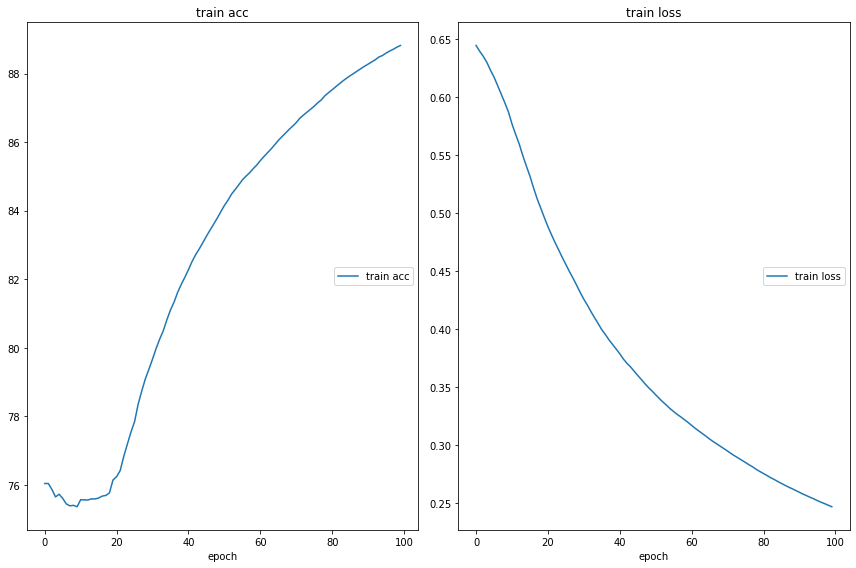

train acc
	train acc        	 (min:   75.365, max:   88.818, cur:   88.818)
train loss
	train loss       	 (min:    0.247, max:    0.644, cur:    0.247)
Finished Training


In [31]:
train_model(clf, train_loader, criterion, optimizer, device, args)

In [15]:
from fair_eval import calculate_prule_clf, calculate_odds_clf, calculate_parity_reg, calculate_group_loss,l2_loss, calculate_overall_accuracy

In [58]:
pred = (clf(torch.tensor(Xte).float())>0.5).float()
pred = pred.cpu().detach().numpy().flatten()

In [59]:
pred_ = clf(torch.tensor(Xte).float())
pred_ = pred_.cpu().detach().numpy().flatten()

In [60]:
print(pred_)

[2.3538221e-01 1.2413255e-03 1.0000000e+00 1.0000000e+00 1.0000000e+00
 1.0000000e+00 1.0000000e+00 2.0511901e-01 1.0000000e+00 9.6937490e-01
 9.9749798e-01 9.9981707e-01 1.0000000e+00 9.9999428e-01 9.9767429e-01
 1.0000000e+00 9.9999225e-01 8.9258230e-01 1.0000000e+00 1.5512447e-01
 3.9171115e-02 1.0000000e+00 1.0000000e+00 1.0000000e+00 1.0000000e+00
 9.9999976e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00 6.2504935e-04
 1.0000000e+00 1.0000000e+00 9.9999893e-01 9.9998915e-01 1.0654778e-04
 8.3752722e-01 1.5092101e-03 6.6149596e-04 9.9966538e-01 1.0000000e+00
 1.0000000e+00 9.9997866e-01 1.5397543e-02 1.0000000e+00 9.9881738e-01
 9.7381896e-01 9.1319686e-01 9.9588531e-01 1.0000000e+00 9.7905046e-01
 5.4246902e-02 1.6641982e-04 1.0000000e+00 1.0000000e+00 1.7419867e-03
 1.0000000e+00 1.0000000e+00 1.3249847e-01 7.8252349e-03 4.2536462e-04
 9.9997997e-01 4.9439285e-02 1.0000000e+00 5.3632051e-01 1.9662890e-03
 1.0000000e+00 9.9866188e-01 9.9999988e-01 9.9997520e-01 2.8819951e-01
 9.997

In [62]:
calculate_prule_clf(pred,yte,Zte)

disparate impact:  78.72340425531915
disparate misclassification rate:  55.769230769230774
disparate false positive rate: 89.1891891891892
disparate false negative rate: 44.94252873563219


In [64]:
calculate_odds_clf(pred,yte.flatten(),Zte)

equalized opportunity for 0.0 : 89.1891891891892
equalized opportunity for 1.0 : 81.34008570315544


In [46]:
calculate_group_loss(bce_loss,pred_,y_te,xs_te)

NameError: name 'bce_loss' is not defined

In [61]:
calculate_overall_accuracy(pred,yte.flatten())

0.7233333333333334

In [78]:
min([1,3,5,6])

1